# Training MobileNetv2 on pooled cytepix and imagestream data

## 27-06-2024

In [1]:
import cv2
import os
import sklearn

import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf
import keras

tf.random.set_seed(42)
keras.backend.clear_session()

2024-07-01 16:19:02.852413: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-01 16:19:02.866923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 16:19:02.887425: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 16:19:02.887447: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 16:19:02.900401: I tensorflow/core/platform/cpu_feature_gua

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

In [4]:
# Get a list of paths for image directories inside of the tire-dataset directory
dataset_path = "/home/t.afanasyeva/deep_learning_anaemias/resources/training"
image_dirs = [dataset_path + "/" + image_dir for image_dir in os.listdir(dataset_path)]

# Loop through name of each image dir and print the number of image files it contains
for image_dir in image_dirs:
    n_files = len(os.listdir(image_dir))
    print("Number of files in %s: " % image_dir + str(n_files))

Number of files in /home/t.afanasyeva/deep_learning_anaemias/resources/training/discocyte: 10282
Number of files in /home/t.afanasyeva/deep_learning_anaemias/resources/training/echinocyte: 2327
Number of files in /home/t.afanasyeva/deep_learning_anaemias/resources/training/granular: 1875
Number of files in /home/t.afanasyeva/deep_learning_anaemias/resources/training/holly_leaf: 4921
Number of files in /home/t.afanasyeva/deep_learning_anaemias/resources/training/sickle: 884


In [5]:
X = []
y = []
for image_dir in image_dirs:
    fnames = [image_dir + "/" + fname for fname in os.listdir(image_dir)]
    for name in fnames:
        img = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
        X.append(img)
        lbl = name.split("/")[6]
        y.append(lbl)
y = pd.DataFrame(y, columns=["class"])

X = np.expand_dims(X, axis=-1).astype(np.float32) / 255  # standartization 0-1

In [6]:
X.shape, y.shape

((20289, 64, 64, 1), (20289, 1))

In [7]:
mobile_net = keras.applications.MobileNetV2(
    input_shape=(64, 64, 1),
    alpha=1.0,
    include_top=True,
    weights=None,
    input_tensor=None,
    pooling=None,
    classes=5,
    classifier_activation="softmax",
)

2024-07-01 16:19:07.260798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 721 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [8]:
from sklearn.model_selection import StratifiedKFold

CV = 3
skf = StratifiedKFold(n_splits=CV, shuffle=True, random_state=93)

In [9]:
earlystopper = keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, verbose=0, mode="min", restore_best_weights=True
)

In [10]:
def learning_rate_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return (lr * tf.math.exp(-0.1)).numpy()


lr_scheduler = keras.callbacks.LearningRateScheduler(learning_rate_schedule)

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay


def get_confusion_matrix(y_pred, y_test):

    fig, ax = plt.subplots(figsize=(8, 8))

    cm = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        ax=ax,
        xticks_rotation="vertical",
        colorbar=False,
        normalize="true",
    )

    plt.rc("font", size=12)
    ax.set_title(f"Confusion Matrix")

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
from sklearn.metrics import (
    confusion_matrix,
    balanced_accuracy_score,
    precision_score,
    f1_score,
)
from keras.utils import to_categorical

In [14]:
scores_list = []
y_pred_list = []
y_test_list = []

BATCH_SIZE = 32
EPOCHES = 200

In [ ]:
with tf.device("GPU:0"):
    for train_index, test_index in skf.split(X, y):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]

        y_test_c = to_categorical(y_test)
        y_train_c = to_categorical(y_train)

        mobile_net.compile(
            loss="categorical_crossentropy",
            optimizer="nadam",
            metrics=["accuracy", keras.metrics.AUC(name="auc")],
        )

        history = mobile_net.fit(
            X_train,
            y_train_c,
            batch_size=BATCH_SIZE,
            epochs=EPOCHES,
            callbacks=[earlystopper, lr_scheduler],
            validation_data=(X_test, y_test_c),
        )

        y_pred = mobile_net.predict(X_test)
        y_pred = y_pred.argmax(axis=1)

        y_pred = le.inverse_transform(y_pred)
        y_test = le.inverse_transform(y_test)

        y_pred_list.extend(y_pred)
        y_test_list.extend(y_test)

        accuracy = balanced_accuracy_score(y_test, y_pred)
        f1_score_model = f1_score(y_test, y_pred, average="weighted")
        precision = precision_score(y_test, y_pred, average="weighted")
        scores = {
            "test_balanced_accuracy": accuracy,
            "test_f1_weighted": f1_score_model,
            "test_precision_weighted": precision,
        }
        scores_per_fold = pd.DataFrame(scores, index=[0])
        scores_list.append(scores_per_fold)


get_confusion_matrix(y_pred_list, y_test_list)
scores_df = pd.concat(scores_list, ignore_index=True)

In [ ]:
scores_df

,test_balanced_accuracy,test_f1_weighted,test_precision_weighted
0,0.790673,0.861755,0.862197


In [ ]:
def plot_history(history, metrics):
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    plt.xlabel("epochs")
    plt.ylabel("metric")

In [ ]:
 history_df = pd.DataFrame.from_dict(history.history)
 history_df

,accuracy,auc,loss,val_accuracy,val_auc,val_loss,learning_rate
0,0.666272,0.911718,8.309974e-01,0.242644,0.697656,1.481727,1.000000e-03
1,0.792178,0.967791,4.958564e-01,0.242644,0.697656,1.499964,1.000000e-03
2,0.839125,0.979007,3.974111e-01,0.242644,0.594041,1.571354,9.048374e-04
3,0.862783,0.984606,3.391939e-01,0.242644,0.594041,1.648009,8.187307e-04
4,0.879491,0.988082,2.982342e-01,0.242644,0.594041,1.767548,7.408181e-04
...,...,...,...,...,...,...,...
156,1.000000,1.000000,3.433937e-07,0.861600,0.929010,1.644707,1.855376e-10
157,1.000000,1.000000,3.433937e-07,0.861600,0.929010,1.644707,1.678813e-10
158,1.000000,1.000000,3.433849e-07,0.861600,0.929010,1.644707,1.519053e-10
159,1.000000,1.000000,3.433937e-07,0.861600,0.929010,1.644707,1.374496e-10


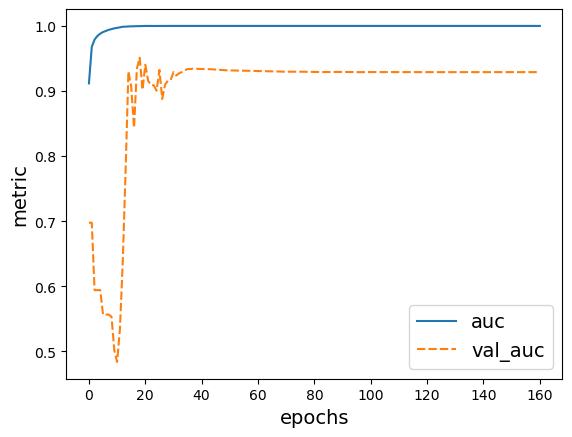

In [ ]:
plot_history(history, ["auc", "val_auc"])

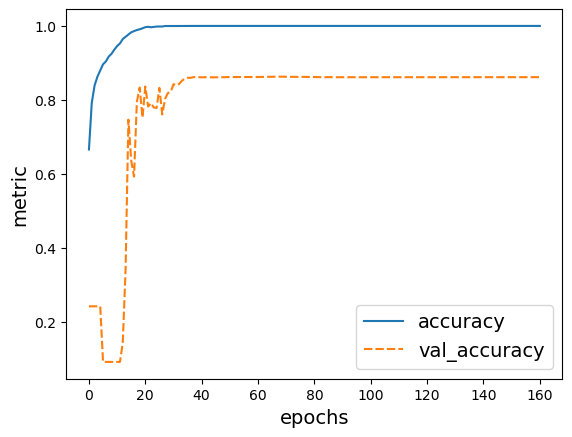

In [ ]:
plot_history(history, ["accuracy", "val_accuracy"])

In [15]:
BATCH_SIZE = 32

In [16]:
with tf.device("GPU:0"):
    # y_c = to_categorical(y)
    mobile_net.compile(
        optimizer="nadam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"],
    )

    mobile_net.fit(
        X,
        y,
        batch_size=BATCH_SIZE,
        epochs=400,
        callbacks=[earlystopper, lr_scheduler],
    )

    mobile_net.save(
        "/home/t.afanasyeva/deep_learning_anaemias/model_zoo/mobile_net_v01.keras"
    )

Epoch 1/400


I0000 00:00:1719843599.629746 3912191 service.cc:145] XLA service 0x7fded007fd30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719843599.629804 3912191 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-07-01 16:20:00.330575: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-01 16:20:02.210212: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  5/635 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.4385 - loss: 1.3940 

I0000 00:00:1719843612.689067 3912191 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


635/635 ━━━━━━━━━━━━━━━━━━━━ 56s 34ms/step - accuracy: 0.6174 - loss: 0.9591 - learning_rate: 0.0010
Epoch 2/400
635/635 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7984 - loss: 0.4885 - learning_rate: 0.0010
Epoch 3/400
635/635 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8392 - loss: 0.3967 - learning_rate: 0.0010
Epoch 4/400
635/635 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8546 - loss: 0.3500 - learning_rate: 0.0010
Epoch 5/400
635/635 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8677 - loss: 0.3233 - learning_rate: 0.0010
Epoch 6/400
635/635 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8805 - loss: 0.2983 - learning_rate: 0.0010
Epoch 7/400
635/635 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8866 - loss: 0.2838 - learning_rate: 0.0010
Epoch 8/400
635/635 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8875 - loss: 0.2792 - learning_rate: 0.0010
Epoch 9/400
635/635 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8948 - loss: 0.2599 - learning_rate: 0.